In [27]:
#Libraries

import matplotlib.pyplot as plt
import os
from glob import glob

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


import cv2
from pathlib import Path
import random

- Obtaining images and captions

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/My\ Drive/data/data > /dev/null

- Functions for visualization

In [4]:
#Given an image, return captions

def extract_captions(image_name, captions_text):
    captions = []
    for line in captions_text.splitlines():
        parts = line.split(',')
        if len(parts) == 2 and parts[0] == image_name:
            captions.append(parts[1])
    return captions

#Visualization of image and some caption

def visualize_images(folder_path, captions, num_images_per_row=2):
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')] # All of them are .jpg
    file_names = file_names[:10]  # Only 10 images

    num_images = len(file_names)
    num_rows = (num_images + num_images_per_row - 1) // num_images_per_row

    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(12, 9))

    for i, file_name in enumerate(file_names):
        img_path = os.path.join(folder_path, file_name)
        img = plt.imread(img_path)
        ax = axes[i // num_images_per_row, i % num_images_per_row]
        ax.imshow(img)
        ax.axis('off')

        caption = extract_captions(file_name, captions)
        ax.text(0.5, -0.15, caption[0], transform=ax.transAxes, fontsize=10, ha='center')

    for j in range(len(file_names), num_rows * num_images_per_row):
        fig.delaxes(axes[j // num_images_per_row, j % num_images_per_row])

    plt.tight_layout()
    plt.show()


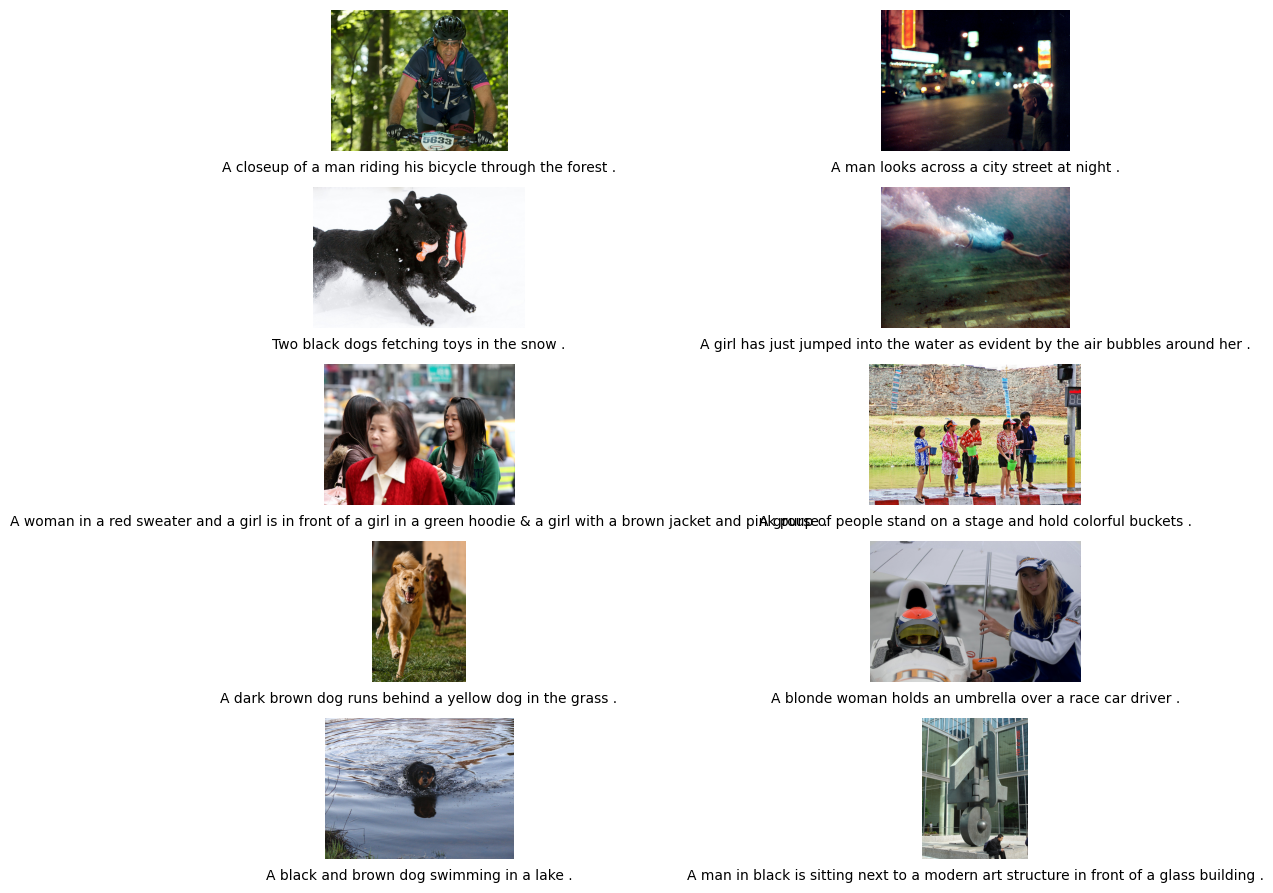

In [9]:
with open("captions.txt", "r") as file:
    captions = file.read()

visualize_images(folder_path= "Images", captions=captions)

- Using ResNet50

In [5]:
# Load the ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 343MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

- Dealing with images

In [22]:
imageFilesDir = Path(r'Images')
files = list(imageFilesDir.rglob('*.jpg'))

mean = np.array([0., 0., 0.])
std = np.array([0., 0., 0.])

numSamples = len(files)

for i in range(numSamples):
    im = cv2.imread(str(files[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) #To RGB
    im = im.astype(float) / 255. # Normalized pixels [0-1]
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j]) # j = 0 - > R, j = 1 - > G, j = 2 - > B
        std[j] += np.std(im[:,:,j])

mean = mean / numSamples
std = std / numSamples

print("Mean:", mean)
print("Standard Deviation:", std)


Mean: [0.45802852 0.44609796 0.40391668]
Standard Deviation: [0.24219123 0.23320058 0.23719894]


In [52]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image: ResNet model  - > (224,224,3)
    transforms.ToTensor(), # Img to Python Tensor
    transforms.Normalize(mean=mean, std=std), # image = (image - mean) / std
])

In [75]:
images_dir = "Images"

file_names = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
random_file = random.choice(file_names) # Pick one image at random

image_path = os.path.join(images_dir, random_file)
original_image = Image.open(image_path).convert('RGB')

normalized_image = preprocess(original_image)
normalized_image = torch.clamp(normalized_image, 0, 1)

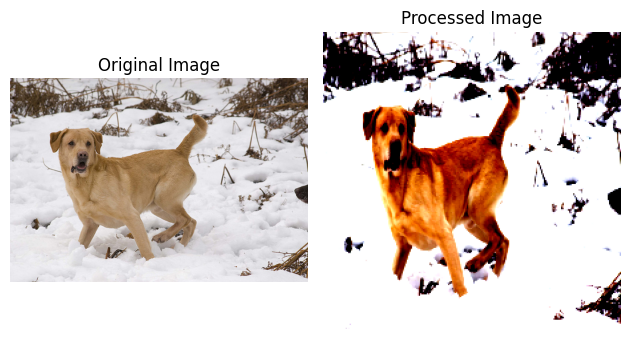

In [78]:
fig, axs = plt.subplots(1, 2)

# Original Image
axs[0].imshow(original_image)
axs[0].set_title("Original Image")

# Preprocessed Image
axs[1].imshow(normalized_image.permute(1, 2, 0))
axs[1].set_title("Processed Image")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

- Extracting Features

In [82]:
# Extracting features from images using ResNet50 😀

def extract_image_features(images_path):

    features = {} # Features dictionary - > IMAGE_NAME : FEATURES
    file_names = [f for f in os.listdir(images_path) if f.endswith('.jpg')]

    file_names = file_names[:40] #Just doing it for 20 images, delete it if you want

    for img_name in file_names:
        img_path = os.path.join(images_path, img_name)

        # print(img_path)

        img = Image.open(img_path).convert('RGB')
        img = preprocess(img)
        img = img.unsqueeze(0)

        feature = model(img)
        feature = torch.flatten(feature, start_dim=1)

        features[img_name] = feature

    return features

In [83]:
images_path = "Images"
features = extract_image_features(images_path)

#shapes = [value.shape for value in features.values()]
#print(shapes)


Just wanted to see if similar images were clustered together in the reduced space (2D).

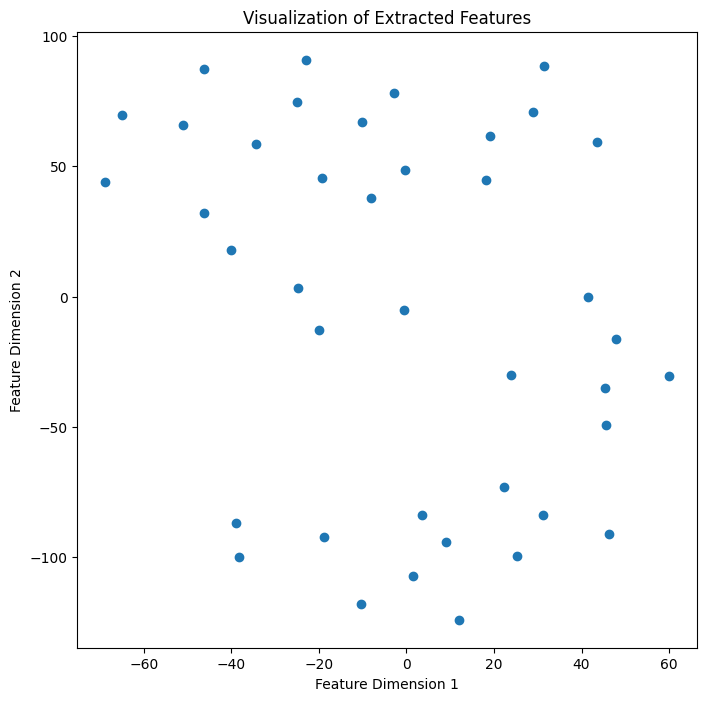

In [84]:
feature_list = list(features.values())
feature_array = np.array([feature.detach().numpy().flatten() for feature in feature_list])

tsne = TSNE(n_components=2, perplexity=9, random_state=42)
embedded_features = tsne.fit_transform(feature_array)

plt.figure(figsize=(8, 8))
plt.scatter(embedded_features[:, 0], embedded_features[:, 1])
plt.title('Visualization of Extracted Features')
plt.xlabel('Feature Dimension 1')
plt.ylabel('Feature Dimension 2')
plt.show()
